In [1]:
import lsst.daf.butler as dafButler
import lsst.daf.persistence as dafPersistence
import numpy as np
import pandas as pd
from collections import Counter
import astropy
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [92]:
# Fred Moolekamp's matching function
def matchSources(catalog, refcat, separation=1*astropy.units.arcsec, refcuts=True):
    # Create coordinates for sources
    coords = astropy.coordinates.SkyCoord(catalog["coord_ra"], catalog["coord_dec"], unit="rad")
    # Create coordinates for truth catalog sources
    refCoords = astropy.coordinates.SkyCoord(refcat["ra"], refcat["dec"], unit="deg")
    
    # Match all sources up to separation
    coordIdx, dist, _ = astropy.coordinates.match_coordinates_sky(coords, refCoords)
    distCuts = dist < separation
    matched = catalog[distCuts]
    coordIdx = coordIdx[distCuts]
    matchedRef = refcat[coordIdx]

    # Keep track of sources with no matches
    unmatched = coords[~distCuts]
    
    # Remove duplicates
    indices, invIndices, count = np.unique(matchedRef["id"], return_inverse=True, return_counts=True)
    countCuts = count[invIndices] == 1
    duplicates = matched[~countCuts]
    matched = matched[countCuts]
    matchedRef = matchedRef[countCuts]
    
    return (
        matched,
        matchedRef,
        dist[distCuts],
        unmatched,
        duplicates
    )

In [3]:
truth_cat_pathname = "/project/hchiang2/qserv/dc2_dr6/truth_match_v2_public/truth_tract3829.parquet"
truth_cat = pd.read_parquet(truth_cat_pathname)
truth_cat

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry
0,7882946295,-1,59.371414,-37.190049,1.834464,0,0,738.781616,781.738708,770.379150,...,"0,0",1,9813,7882946295,24.183239,16840120091018685,0.021938,True,True,True
1,7877763181,-1,59.349060,-37.189784,1.032970,0,0,11.965725,13.751044,20.297436,...,"0,0",1,9813,7877763181,28.131397,16840120091018697,1.052619,False,True,True
2,7881004314,-1,59.353061,-37.190082,1.581916,0,0,216.708954,209.086319,189.395660,...,"0,0",1,9813,7881004314,25.706575,16840120091018698,0.089409,True,True,True
3,7875855854,-1,59.360404,-37.189926,0.644448,0,0,23.845154,47.085804,131.364227,...,"0,0",1,9813,7875855854,26.103806,16840120091018702,0.060800,True,True,True
4,7882946285,-1,59.372850,-37.189428,1.836738,0,0,249.917206,343.710663,448.072266,...,"0,0",1,9813,7882946285,24.771631,16840120091018716,0.035063,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4673845,8756454760,-1,57.657676,-37.189581,1.669529,0,0,2.413941,9.788366,16.380201,...,"6,0",1,9940,8756454760,28.364202,-1,-1.000000,False,False,True
4673846,8758494821,-1,57.662224,-37.188723,1.920959,0,0,5.025790,17.674282,23.433764,...,"6,0",1,9940,8758494821,27.975395,-1,-1.000000,False,False,True
4673847,8758494824,-1,57.662936,-37.188786,1.920980,0,0,37.037621,44.605274,39.307751,...,"6,0",1,9940,8758494824,27.413805,-1,-1.000000,False,False,True
4673848,8758494830,-1,57.661476,-37.188731,1.920371,0,0,16.446449,24.385708,23.406212,...,"6,0",1,9940,8758494830,27.976673,-1,-1.000000,False,False,True


In [66]:
subcat_patches = ('5,2', '5,3', '5,4', '6,2', '6,3', '6,4')
subcat_cuts = ~truth_cat.patch.isin(subcat_patches)
subcat_cuts.mean()

0.8770411972998705

In [67]:
truth_subcat = truth_cat.drop(list(truth_cat.index[subcat_cuts]), inplace=False)
truth_subcat

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry
738167,6881833667,-1,58.062468,-36.497297,1.679284,0,0,120.796799,106.737694,91.209122,...,"5,3",1,9684,6881833667,26.499903,16840682731766914,0.779479,False,True,False
746532,6876778685,-1,58.063039,-36.383703,0.868548,0,0,25.969011,30.211075,41.459290,...,"5,3",1,9684,6876778685,27.355946,16840682731775654,0.294794,True,True,True
752942,6875693748,-1,58.063808,-36.245897,0.606261,0,0,47.133205,61.579052,115.084129,...,"5,4",1,9684,6875693748,26.247461,16840687026704923,0.050912,True,True,True
869261,6888690724,-1,57.854195,-36.777884,2.122401,0,0,136.665558,218.834305,176.715607,...,"5,2",1,9684,6888690724,25.781813,16840811580802343,0.341504,True,False,False
869773,6875889814,-1,57.981895,-36.778494,0.672225,0,0,30.670038,46.799610,99.689377,...,"5,2",1,9684,6875889814,26.403378,16840815875719459,0.181418,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212199,7889785289,-1,58.058023,-36.777508,2.172613,0,0,13.653140,16.524353,15.388789,...,"5,2",1,9813,7889785289,28.431988,-1,-1.000000,False,False,True
4217566,7882840606,-1,58.054899,-36.773824,1.790182,0,0,5.758640,9.746288,11.597810,...,"5,2",1,9813,7882840606,28.739059,-1,-1.000000,False,False,True
4218504,7882849886,-1,58.058575,-36.774655,1.762761,0,0,15.641724,15.802482,14.677137,...,"5,2",1,9813,7882849886,28.483395,-1,-1.000000,False,False,True
4240359,7887524215,-1,58.056862,-36.778006,2.000759,0,0,5.525891,12.789588,15.243738,...,"5,2",1,9813,7887524215,28.442270,-1,-1.000000,False,False,True


In [249]:
# "u/kannawad/june21-scipipe-sprint/20210622T042849Z" has 20-29
collections = ["u/kannawad/june21-scipipe-sprint/20210619T225911Z",
               "u/kannawad/june21-scipipe-sprint/20210622T052648Z",
               "u/kannawad/june21-scipipe-sprint/20210622T151909Z"]
tract, patch = 3829, 16
butler = dafButler.Butler("/repo/dc2", collections=collections)

In [250]:
meas_dict = {}
for band in ("i", "r", "z", "y", "g", "u"):
    meas_dict[band] = butler.get("deepCoadd_meas", tract=tract, band=band, patch=patch)

In [251]:
[nam for nam in meas_dict['g'].asAstropy().columns if 'gaap' in nam ]

['ext_gaap_GaapFlux_1_15x_0_7_instFlux',
 'ext_gaap_GaapFlux_1_15x_0_7_instFluxErr',
 'ext_gaap_GaapFlux_1_15x_1_0_instFlux',
 'ext_gaap_GaapFlux_1_15x_1_0_instFluxErr',
 'ext_gaap_GaapFlux_OptimalShape_xx',
 'ext_gaap_GaapFlux_OptimalShape_yy',
 'ext_gaap_GaapFlux_OptimalShape_xy',
 'ext_gaap_GaapFlux_1_15x_Optimal_instFlux',
 'ext_gaap_GaapFlux_1_15x_Optimal_instFluxErr',
 'ext_gaap_GaapFlux_1_15x_0_7_flag_bigPsf',
 'ext_gaap_GaapFlux_1_15x_0_7_flag',
 'ext_gaap_GaapFlux_1_15x_1_0_flag_bigPsf',
 'ext_gaap_GaapFlux_1_15x_1_0_flag',
 'ext_gaap_GaapFlux_1_15x_Optimal_flag_bigPsf',
 'ext_gaap_GaapFlux_1_15x_Optimal_flag',
 'ext_gaap_GaapFlux_1_15x_flag_gaussianization',
 'ext_gaap_GaapFlux_flag_edge',
 'ext_gaap_GaapFlux_flag',
 'ext_gaap_GaapFlux_1_15x_0_7_apCorr',
 'ext_gaap_GaapFlux_1_15x_0_7_apCorrErr',
 'ext_gaap_GaapFlux_1_15x_0_7_flag_apCorr',
 'ext_gaap_GaapFlux_1_15x_1_0_apCorr',
 'ext_gaap_GaapFlux_1_15x_1_0_apCorrErr',
 'ext_gaap_GaapFlux_1_15x_1_0_flag_apCorr',
 'ext_gaap_Gaa

In [252]:
obj = butler.get("objectTable_tract", tract=3829)

In [253]:
Counter(obj['patch'])

Counter({10: 32664,
         11: 32342,
         12: 35044,
         13: 30613,
         14: 28434,
         15: 29590,
         16: 31197,
         17: 31455,
         18: 30378,
         19: 33380})

In [254]:
list(obj.columns)

['parentObjectId',
 'detect_isDeblendedSource',
 'coord_ra',
 'coord_dec',
 'x',
 'riStd',
 'detect_isPrimary',
 'refFwhm',
 'xErr',
 'detect_isIsolated',
 'zyStd',
 'objectId',
 'grStd',
 'refExtendedness',
 'yErr',
 'detect_fromBlend',
 'izStd',
 'tractId',
 'xy_flag',
 'merge_peak_sky',
 'refBand',
 'patchId',
 'detect_isDeblendedModelSource',
 'detect_isPatchInner',
 'detect_isTractInner',
 'y',
 'skymap',
 'tract',
 'patch',
 'uRa',
 'uDecl',
 'uPsFlux',
 'uPsFluxErr',
 'uBdE1',
 'uBdE2',
 'uBdReB',
 'uBdReD',
 'uBdChi2',
 'uBdFluxB',
 'uBdFluxBErr',
 'uBdFluxD',
 'uBdFluxDErr',
 'uMatchedApPsfFlux',
 'uMatchedApPsfFluxErr',
 'uMatchedAp0p7Flux',
 'uMatchedAp0p7FluxErr',
 'uMatchedAp1p0Flux',
 'uMatchedAp1p0FluxErr',
 'uMatchedApOptimalFlux',
 'uMatchedApOptimalFluxErr',
 'uIxx',
 'uIyy',
 'uIxy',
 'uIxxPsf',
 'uIyyPsf',
 'uIxyPsf',
 'uKronRad',
 'uKronFlux',
 'uKronFluxErr',
 'uApFlux',
 'uApFluxErr',
 'uAp25Flux',
 'uAp25FluxErr',
 'uExtendedness',
 'uBlendedness',
 'uFwhm',
 'u

57.50373170452323 59.44764766378963 -37.007040631832574 -36.54838452473023


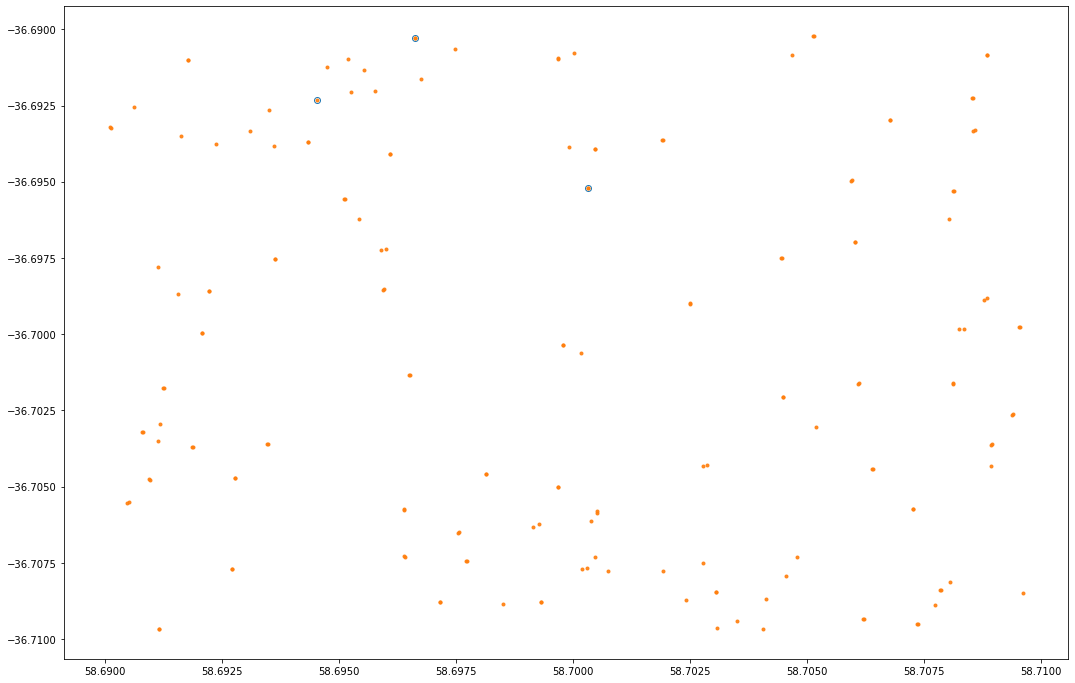

In [300]:
fig, ax = plt.subplots()
fig.set_size_inches([18, 12])
ra_min, ra_max = 58.69, 58.71
dec_min, dec_max = -36.71, -36.69
# ra_min, ra_max = -np.inf, np.inf
# dec_min, dec_max = -np.inf, np.inf
cuts = (truth_cat['ra']>ra_min)&(truth_cat['ra']<ra_max)&(truth_cat['dec']>dec_min)&(truth_cat['dec']<dec_max) & truth_cat['is_pointsource']
ax.plot(truth_cat['ra'][cuts], truth_cat['dec'][cuts], 'o', fillstyle='none')
x, y = obj['coord_ra'], obj['coord_dec'] #*180./np.pi
cuts = (x>ra_min)&(x<ra_max)&(y>dec_min)&(y<dec_max)
print(x.min(), x.max(), y.min(), y.max())
ax.plot(x[cuts], y[cuts], '.', color='C1',alpha=0.9)

In [258]:
%%time
truth_coord = astropy.coordinates.SkyCoord(truth_cat['ra'], truth_cat['dec'], unit='deg')
meas_coord = astropy.coordinates.SkyCoord(obj['coord_ra'], obj['coord_dec'], unit='deg')

In [259]:
%%time
idx, dist2d, dist3d = astropy.coordinates.match_coordinates_sky(meas_coord, truth_coord)
# matched_meas = {}
# for band in ('g',):
#    matched_meas[band], truth_matched, _dist, _unmatched, _dup = matchSources(meas_dict[band], truth_cat)

CPU times: user 2.55 s, sys: 160 ms, total: 2.71 s
Wall time: 2.71 s


In [260]:
cntr = Counter(idx[dist2d.arcsec<0.1])
duplicates = [(k,v) for k,v in cntr.items() if v>1]
print(len(duplicates), len(cntr), len(idx), (dist2d.arcsec<1).sum())

58390 110448 315097 294747


In [302]:
# isUnique is True if idx occurs only once after filtering out by dist2d
isUnique = np.isin(idx, [k for k,v in Counter(idx[dist2d.arcsec<1]).items() if v==1], assume_unique=False)
isPointSource = np.array(truth_cat['is_pointsource'][idx], dtype=bool)
isVariable = np.array(truth_cat['is_variable'][idx], dtype=bool)
cuts = isUnique & (dist2d.arcsec<1)
cuts.sum(), isPointSource.sum(), (cuts & isPointSource).sum()

(57609, 9829, 777)

315097 294747


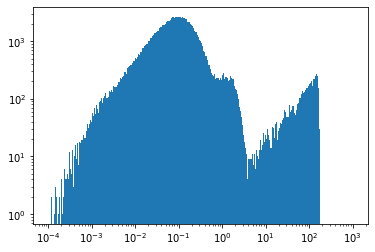

In [262]:
print(len(idx), (dist2d.arcsec<1).sum())
bins = np.logspace(-4, 3,701)
_ = plt.hist(dist2d.arcsec, bins=bins)
plt.xscale('log')
plt.yscale('log')

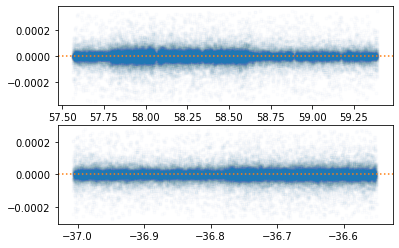

In [268]:
fig, ax = plt.subplots(2)
cuts = isUnique & (dist2d.arcsec<1)
ax[0].plot(truth_coord.ra[idx][cuts], meas_coord.ra[cuts]-truth_coord.ra[idx][cuts], '.', alpha=0.01)
ax[1].plot(truth_coord.dec[idx][cuts], meas_coord.dec[cuts]-truth_coord.dec[idx][cuts], '.', alpha=0.01)
for _ax in ax:
    _ax.axhline(0.0, color='C1', ls=':')

In [112]:
for rec in meas:
    if rec.getId()==1650736389198719158:
        break
print(rec)

id: 1650736389198719158
coord_ra: 1.0172 rad
coord_dec: -0.626456 rad
parent: 0
merge_footprint_i: 0
merge_footprint_r: 0
merge_footprint_z: 1
merge_footprint_y: 0
merge_footprint_g: 0
merge_footprint_u: 0
merge_footprint_sky: 0
merge_peak_i: 0
merge_peak_r: 0
merge_peak_z: 1
merge_peak_y: 0
merge_peak_g: 0
merge_peak_u: 0
merge_peak_sky: 0
deblend_runtime: 341.72
deblend_iterations: 29
deblend_nChild: 1
deblend_deblendedAsPsf: 0
deblend_tooManyPeaks: 0
deblend_parentTooBig: 0
deblend_masked: 0
deblend_sedConvergenceFailed: 0
deblend_morphConvergenceFailed: 0
deblend_blendConvergenceFailedFlag: 1
deblend_edgePixels: 0
deblend_failed: 0
deblend_error:  
deblend_skipped: 0
deblend_peak_center_x: 0
deblend_peak_center_y: 0
deblend_peakId: 0
deblend_peak_instFlux: nan
deblend_modelType:  
deblend_nPeaks: 1
deblend_parentNPeaks: 0
deblend_parentNChild: 0
deblend_scarletFlux: nan
deblend_logL: 255.804
deblend_spectrumInitFlag: 1
base_NaiveCentroid_x: 16856.1
base_NaiveCentroid_y: 23949.9
bas

In [245]:
for meas_cat in meas_dict.values():
    print(len(meas_cat))

29911
29911
29911
29911
29911
29911


In [107]:
rec_dict = {}
for band, meas_tmp in meas_dict.items():
    for rec in meas_tmp:
        if rec.getId()==1650736389198719158:
            rec_dict[band] = rec

In [108]:
for band in ("i", "r", "z", "y", "g", "u"):
    print(rec_dict[band]["base_PsfFlux_instFlux"]/rec_dict[band]["base_PsfFlux_instFluxErr"], rec_dict[band]["base_PsfFlux_flag"])
    print(rec_dict[band].getParent())

3.1383233487746125 True
0
3.904444176835903 False
0
5.837415497848272 False
0
2.163987196292509 False
0
1.4951328367735859 False
0
-1.073166173599819 True
0


In [262]:
[nam for nam in meas.schema.getNames() if ('model' in nam)&('instFlux' in nam)]

['modelfit_CModel_exp_instFlux_inner',
 'modelfit_CModel_exp_instFluxErr',
 'modelfit_CModel_initial_instFlux',
 'modelfit_CModel_dev_instFlux',
 'modelfit_CModel_instFlux',
 'modelfit_CModel_instFlux_inner',
 'modelfit_CModel_instFluxErr',
 'modelfit_CModel_initial_instFlux_inner',
 'modelfit_CModel_dev_instFluxErr',
 'modelfit_CModel_exp_instFlux',
 'modelfit_CModel_initial_instFluxErr',
 'modelfit_CModel_dev_instFlux_inner']

In [212]:
print(truth_cat.columns)
Counter(truth_cat['truth_type'])

Index(['id', 'host_galaxy', 'ra', 'dec', 'redshift', 'is_variable',
       'is_pointsource', 'flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z',
       'flux_y', 'flux_u_noMW', 'flux_g_noMW', 'flux_r_noMW', 'flux_i_noMW',
       'flux_z_noMW', 'flux_y_noMW', 'tract', 'patch', 'truth_type',
       'cosmodc2_hp', 'cosmodc2_id', 'mag_r', 'match_objectId', 'match_sep',
       'is_good_match', 'is_nearest_neighbor', 'is_unique_truth_entry'],
      dtype='object')


Counter({1: 4642987, 2: 28073, 3: 2790})

In [38]:
set(Counter(truth_cat.patch[idx][dist2d.arcsec<2]).keys())

{'5,2', '5,3', '5,4', '6,2', '6,3', '6,4'}

/software/lsstsw/stack_20210520/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/pandas/core/arrays/numpy_.py:237: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/software/lsstsw/stack_20210520/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/pandas/core/arrays/numpy_.py:237: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/software/lsstsw/stack_20210520/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/pandas/core/arrays/numpy_.py:237: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-0.05, 0.05)

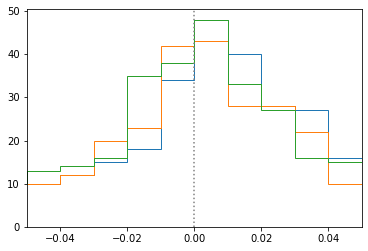

In [345]:
fig, ax = plt.subplots()
cuts = isUnique & (dist2d.arcsec<1) * isPointSource
bins = np.linspace(-1, 1, 201)
for gaapName in ('MatchedApOptimalFlux', 'CModelFlux', 'PsFlux'):
    meas_color = -2.5*np.log10(obj[cuts]['g'+gaapName].array/obj[cuts]['r'+gaapName].array)
    true_color = -2.5*np.log10(truth_cat['flux_g'][idx][cuts]/truth_cat['flux_r'][idx][cuts])
    _ = ax.hist(meas_color-true_color, bins=bins, histtype='step', label=gaapName)

ax.axvline(0.0, color='gray', ls=':')
ax.set_xlim([-0.05,0.05])
# ax.set_yscale('log')
# ax.legend(loc='best')

In [279]:
flux = obj[cuts]['gCModelFlux']
type(flux)

pandas.core.series.Series

In [285]:
flux.array

<PandasArray>
[128.00892493369716, 144.45720574918568, 142.08490394728608,
 153.15257265985895,  440.7704899645024, 142.12491987578892,
  527.9904901881052, 160.93196374784628,  311.7957927025756,
 211.74984849222963,
 ...
   189.286917437823, 109.39641842111376,   89.1472306518965,
 101.24050675957155,  82.12789662220518, 101.36854581513968,
 113.35421545787672, 112.92151675619844,  93.13759316956157,
  265.8796782137867]
Length: 57609, dtype: float64

/software/lsstsw/stack_20210520/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/pandas/core/arrays/numpy_.py:237: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/software/lsstsw/stack_20210520/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/pandas/core/arrays/numpy_.py:237: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.
/software/lsstsw/stack_20210520/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/pandas/core/arrays/numpy_.py:237: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/software/lsstsw/stack_20210520/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/pandas/core/arrays/n

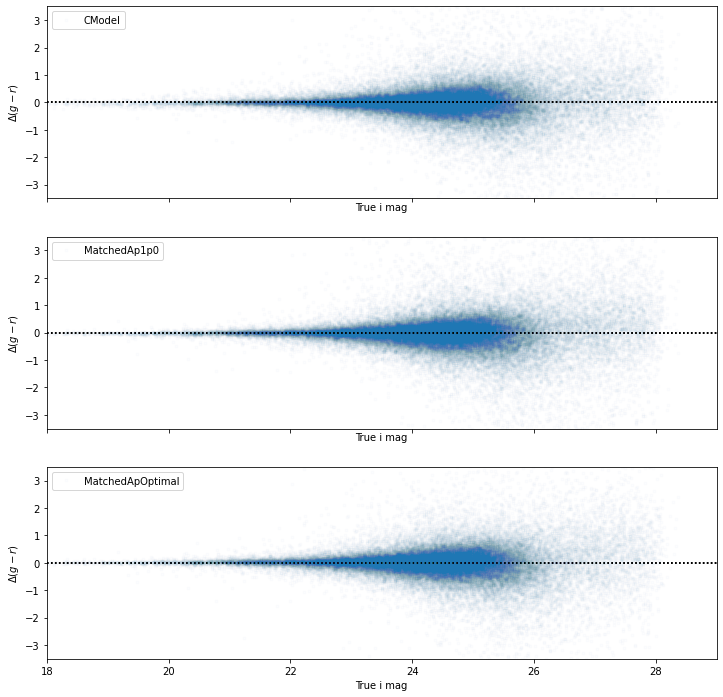

In [375]:
fig, ax = plt.subplots(3,sharex=True,sharey=True)
fig.set_size_inches([12,12])
for gid, gaapName in enumerate(( 'CModelFlux', 'MatchedAp1p0Flux', 'MatchedApOptimalFlux')):
    cuts = isUnique & (~isPointSource) & (dist2d.arcsec<1) #& (~obj['g'+gaapName.replace('_instFlux','_flag')]) & (~meas_dict['r'][gaapName.replace('_instFlux','_flag')])
    X = -2.5*np.log10(truth_cat['flux_i'][idx][cuts]) + 30.4
    gr_meas = -2.5*np.log10(obj[cuts]['g'+gaapName].array/obj[cuts]['r'+gaapName].array)
    gr_true = -2.5*np.log10(truth_cat['flux_g'][idx][cuts]/truth_cat['flux_r'][idx][cuts])
    ax[gid].plot(X, gr_meas-gr_true,'.', alpha=0.01, label=gaapName.replace('Flux', ''))
    for _ax in ax:
        #_ax.set_title(f"{cuts.sum()} / {len(idx)}")
        _ax.axhline(0.0, color='k', ls=':')
        _ax.set_xlabel('True i mag')
        _ax.set_ylim([-3.5, 3.5])
        _ax.set_xlim([18,29])
        _ax.set_ylabel(r'$\Delta (g-r)$')
        _ax.legend(loc='best')
        

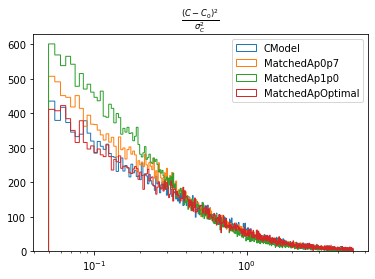

In [392]:
fig, ax = plt.subplots(1)
# fig.set_size_inches([12,12])
bins = np.linspace(0.05, 5, 1001)
for gid, gaapName in enumerate(( 'CModelFlux', 'MatchedAp0p7Flux', 'MatchedAp1p0Flux', 'MatchedApOptimalFlux')):
    cuts = isUnique & (~isPointSource) & (dist2d.arcsec<1) #& (~obj['g'+gaapName.replace('_instFlux','_flag')]) & (~meas_dict['r'][gaapName.replace('_instFlux','_flag')])
    X = -2.5*np.log10(truth_cat['flux_i'][idx][cuts]) + 30.4
    
    gr_meas =  obj[cuts]['g'+gaapName].array/obj[cuts]['r'+gaapName].array
    gr_true = truth_cat['flux_g'][idx][cuts]/truth_cat['flux_r'][idx][cuts]
    
    chi2 = ( gr_meas - gr_true )
    chi2err = (np.abs(obj[cuts]['g'+gaapName+'Err'].array * obj[cuts]['r'+gaapName].array) + np.abs(obj[cuts]['r'+gaapName+'Err'].array * obj[cuts]['g'+gaapName].array))/obj[cuts]['r'+gaapName].array**2
    
    Y = (chi2/chi2err)**2
    ax.hist(Y, bins=bins, histtype='step', label=gaapName.replace('Flux', ''))
    if gid==14:
        ax[1].plot(X, Y, '.', alpha=0.1, label=gaapName.replace('Flux', ''))
    #_ax.set_title(f"{cuts.sum()} / {len(idx)}")
    #ax.axhline(0.0, color='k', ls=':')
    #ax.set_xlabel('True i mag')
    #ax.set_ylim([-3.5, 3.5])
    #ax.set_xlim([18,29])
    #ax.set_ylabel(r'$\Delta (g-r)$')
    ax.set_xscale('log')
    ax.set_title(r"$\frac{(C-C_0)^2}{\sigma_C^2}$", rotation=0)
    # ax.set_ylim([-0.5,20])
    ax.legend(loc='best')
    # ax[1].legend(loc='best')
        

In [324]:
butl = dafButler.Butler("/repo/dc2", collections="2.2i/runs/test-med-1/")
for tract in range(2553, 5074+1):
    try:
        _obj = butl.get('objectTable_tract', tract=tract)
        plt.hist((0.5*(_obj['iIxxPsf']+_obj['iIyyPsf']))**0.5, bins=bins, histtype='step', label=f"{tract}")
    except:
        pass